In [1]:
import sys
import json
import h5py
import trimesh
from pathlib import Path
import argparse
import numpy as np
import trimesh.path
from shapely.geometry import Point

from acronym_tools import Scene, load_mesh, load_grasps, create_gripper_marker
import easydict

In [5]:
def custom_parser():
    # object는 parser.add_argument( ~ , nargs="+") , nargs="+" 때문에 list로 arg 셋팅함
    args = easydict.EasyDict({
        "objects" : ["/home/juju/acronym/data/grasps/Book_4698973d47c780654f48c7d5931203ac_0.01010965467789813.h5", "/home/juju/acronym/data/grasps/Bag_b914f95b191ad7c27f91c3974257b780_0.012715081291695372.h5", "/home/juju/acronym/data/grasps/Bowl_2efc35a3625fa50961a9876fa6384765_0.012449533111417973.h5"],
        "support" : "/home/juju/acronym/data/grasps/3Shelves_29b66fc9db2f1558e0e89fd83955713c_0.0025867867973150068.h5",
        "num_grasps" : 5,
        "mesh_root" : '/home/juju/acronym/data/',
        "support_scale" : 0.025
    })
    return args

In [6]:
show_scene = True

### Pyrenderer

In [8]:
class PyrenderScene(Scene):
    def as_pyrender_scene(self):
        """Return pyrender scene representation.

        Returns:
            pyrender.Scene: Representation of the scene
        """
        pyrender_scene = pyrender.Scene()
        for obj_id, obj_mesh in self._objects.items():
            mesh = pyrender.Mesh.from_trimesh(obj_mesh, smooth=False)
            pyrender_scene.add(mesh, name=obj_id, pose=self._poses[obj_id])
        return pyrender_scene


In [25]:
class SceneRenderer:
    def __init__(
        self,
        pyrender_scene,
        fov=np.pi / 6.0,
        width=400,
        height=400,
        aspect_ratio=1.0,
        z_near=0.001,
    ):
        """Create an image renderer for a scene.

        Args:
            pyrender_scene (pyrender.Scene): Scene description including object meshes and their poses.
            fov (float, optional): Field of view of camera. Defaults to np.pi/6.
            width (int, optional): Width of camera sensor (in pixels). Defaults to 400.
            height (int, optional): Height of camera sensor (in pixels). Defaults to 400.
            aspect_ratio (float, optional): Aspect ratio of camera sensor. Defaults to 1.0.
            z_near (float, optional): Near plane closer to which nothing is rendered. Defaults to 0.001.
        """
        self._fov = fov
        self._width = width
        self._height = height
        self._z_near = z_near
        self._scene = pyrender_scene

        self._camera = pyrender.PerspectiveCamera(
            yfov=fov, aspectRatio=aspect_ratio, znear=z_near
        )

    def get_trimesh_camera(self):
        """Get a trimesh object representing the camera intrinsics.

        Returns:
            trimesh.scene.cameras.Camera: Intrinsic parameters of the camera model
        """
        return trimesh.scene.cameras.Camera(
            fov=(np.rad2deg(self._fov), np.rad2deg(self._fov)),
            resolution=(self._height, self._width),
            z_near=self._z_near,
        )

    def _to_pointcloud(self, depth):
        """Convert depth image to pointcloud given camera intrinsics.

        Args:
            depth (np.ndarray): Depth image.

        Returns:
            np.ndarray: Point cloud.
        """
        fy = fx = 0.5 / np.tan(self._fov * 0.5)  # aspectRatio is one.
        height = depth.shape[0]
        width = depth.shape[1]

        mask = np.where(depth > 0)

        x = mask[1]
        y = mask[0]

        normalized_x = (x.astype(np.float32) - width * 0.5) / width
        normalized_y = (y.astype(np.float32) - height * 0.5) / height

        world_x = normalized_x * depth[y, x] / fx
        world_y = normalized_y * depth[y, x] / fy
        world_z = depth[y, x]
        ones = np.ones(world_z.shape[0], dtype=np.float32)

        return np.vstack((world_x, world_y, world_z, ones)).T

    def render(self, camera_pose, target_id="", render_pc=True):
        """Render RGB/depth image, point cloud, and segmentation mask of the scene.

        Args:
            camera_pose (np.ndarray): Homogenous 4x4 matrix describing the pose of the camera in scene coordinates.
            target_id (str, optional): Object ID which is used to create the segmentation mask. Defaults to ''.
            render_pc (bool, optional): If true, point cloud is also returned. Defaults to True.

        Returns:
            np.ndarray: Color image.
            np.ndarray: Depth image.
            np.ndarray: Point cloud.
            np.ndarray: Segmentation mask.
        """
        # Keep local to free OpenGl resources after use
        renderer = pyrender.OffscreenRenderer(
            viewport_width=self._width, viewport_height=self._height
        )

        # add camera and light to scene
        scene = self._scene.as_pyrender_scene()
        scene.add(self._camera, pose=camera_pose, name="camera")
        light = pyrender.SpotLight(
            color=np.ones(4),
            intensity=3.0,
            innerConeAngle=np.pi / 16,
            outerConeAngle=np.pi / 6.0,
        )
        scene.add(light, pose=camera_pose, name="light")

        # render the full scene
        color, depth = renderer.render(scene)

        segmentation = np.zeros(depth.shape, dtype=np.uint8)

        # hide all objects
        for node in scene.mesh_nodes:
            node.mesh.is_visible = False

        # Render only target object and add to segmentation mask
        for node in scene.mesh_nodes:
            if node.name == target_id:
                node.mesh.is_visible = True
                _, object_depth = renderer.render(scene)
                mask = np.logical_and(
                    (np.abs(object_depth - depth) < 1e-6), np.abs(depth) > 0
                )
                segmentation[mask] = 1

        for node in scene.mesh_nodes:
            node.mesh.is_visible = True

        if render_pc:
            pc = self._to_pointcloud(depth)
        else:
            pc = None

        return color, depth, pc, segmentation

import pyrender
import matplotlib.pyplot as plt


# Main

In [26]:
args = custom_parser()

In [27]:
object_meshes = [load_mesh(o, mesh_root_dir=args.mesh_root) for o in args.objects]
support_mesh = load_mesh(
    args.support, mesh_root_dir=args.mesh_root, scale=args.support_scale
)
scene = PyrenderScene.random_arrangement(object_meshes, support_mesh)

target_obj = "obj0"

In [28]:
# choose camera intrinsics and extrinsics
renderer = SceneRenderer(scene)
trimesh_camera = renderer.get_trimesh_camera()
camera_pose = trimesh_camera.look_at(
    points=[scene.get_transform(target_obj, frame="com")[:3, 3]],
    rotation=trimesh.transformations.euler_matrix(
        np.random.uniform(low=np.pi / 4, high=np.pi / 3),
        0,
        np.random.uniform(low=-np.pi, high=np.pi),
    ),
    distance=np.random.uniform(low=0.7, high=0.9),
)


In [29]:

if show_scene:
    # show scene, including a marker representing the camera
    trimesh_scene = scene.colorize({target_obj: [255, 0, 0]}).as_trimesh_scene()
    trimesh_scene.add_geometry(
        trimesh.creation.camera_marker(trimesh_camera),
        node_name="camera",
        transform=camera_pose.dot(
            trimesh.transformations.euler_matrix(np.pi, 0, 0)
        ),
    )
    trimesh_scene.show()

# render observations
color, depth, pc, segmentation = renderer.render(
    camera_pose=camera_pose, target_id=target_obj
)


In [53]:
len(pc)

129662

In [54]:
np.min(pc[:,2])

0.590269

In [51]:
np.where(pc[:,2] == np.min(pc[:,2]))

(array([129344, 129345, 129346, 129347, 129348, 129349, 129350, 129351,
        129352, 129353, 129354, 129355, 129356, 129357, 129358, 129359,
        129360, 129361, 129362, 129363, 129364, 129365, 129366, 129367,
        129368, 129369, 129370, 129371, 129372, 129373, 129374, 129375,
        129376, 129377, 129378, 129379, 129380, 129381, 129382, 129383,
        129384, 129385, 129386, 129387, 129388, 129389, 129390, 129391,
        129392, 129393, 129394, 129395, 129396, 129397, 129398, 129399,
        129400, 129401, 129402, 129403, 129404, 129405, 129406, 129407,
        129408, 129409, 129410, 129411, 129412, 129413, 129414, 129415,
        129416, 129417, 129418, 129419, 129420, 129421, 129422, 129423,
        129424, 129425, 129426, 129427, 129428, 129429, 129430, 129431,
        129432, 129433, 129434, 129435, 129436, 129437, 129438, 129439,
        129440, 129441, 129442, 129443, 129444, 129445, 129446, 129447,
        129448, 129449, 129450, 129451, 129452, 129453, 129454, 

In [57]:
pc[129345],pc[129473]

(array([-0.1573713,  0.1573713,  0.590269 ,  1.       ], dtype=float32),
 array([-0.05614755,  0.1573713 ,  0.590269  ,  1.        ], dtype=float32))

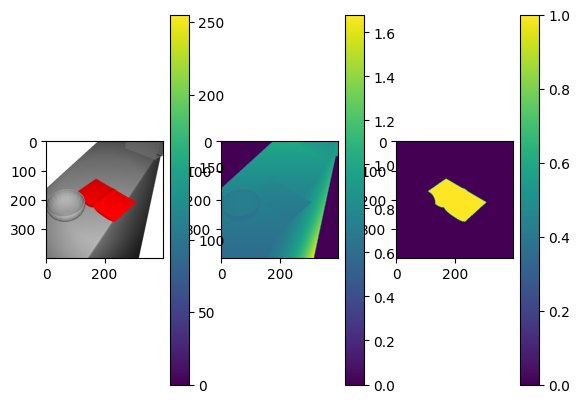

In [31]:
# plot everything except point cloud
f, axarr = plt.subplots(1, 3)
im = axarr[0].imshow(color)
f.colorbar(im, ax=axarr[0])
im = axarr[1].imshow(depth)
f.colorbar(im, ax=axarr[1])
im = axarr[2].imshow(segmentation)
f.colorbar(im, ax=axarr[2])
plt.show()
